In [1]:
# import libraries
import numpy as np
from sklearn import preprocessing
from keras import Model
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
import pickle

# disable warnings to ignore overflow error
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
# convert numpy array to tensor
def to_tensor(x):
    return tf.convert_to_tensor(x, dtype=tf.float32)

In [14]:
# normal training loop
def train_data_driven(model, n_epochs):
    optimizer = tf.keras.optimizers.Adam()

    for epoch in range(1,n_epochs+1):

        for step, (x, y) in enumerate(train_dataset):

            with tf.GradientTape() as tape:
                NN_output = model(x)
                y = tf.cast(y, tf.float32)
                loss = tf.reduce_mean((NN_output - y)**2)

            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

#         if epoch % 100 == 0:
#             print("Training loss: ", loss)

    return model

In [13]:
# physics-informed training loop
def train(model, n_epochs, x_collocation):
    optimizer = tf.keras.optimizers.Adam()

    mean_X = to_tensor(scaler_X_batch.mean_)
    std_X = to_tensor(np.sqrt(scaler_X_batch.var_))
    mean_y = to_tensor(scaler_y_batch.mean_)
    std_y = to_tensor(np.sqrt(scaler_y_batch.var_))

    for epoch in range(1,n_epochs+1):

        for step, (x, y) in enumerate(train_dataset):

            with tf.GradientTape() as tape:
                NN_output = model(x)
                y = tf.cast(y, tf.float32)
                loss1 = K.mean((NN_output[:, :, :] - y[:, :, :])**2)

                NN_output = model(x_collocation)

                CA_NN_input = x_collocation[:, :, 1] * std_X[1] + mean_X[1] + C_As
                T_NN_input = x_collocation[:, :, 0] * std_X[0] + mean_X[0] + T_s
                Q = x_collocation[:, :, 2] * std_X[2] + mean_X[2] + Q_s_new_batch

                NN_output = NN_output * std_y + mean_y + to_tensor(np.array([T_s, C_As]))

                dCA_first = (NN_output[:, 1:2, 1] - CA_NN_input[:, 0:1]) / (2*t_step*50)
                dT_first = (NN_output[:, 1:2, 0] - T_NN_input[:, 0:1]) / (2*t_step*50)

                dCA_center = (NN_output[:, 2:, 1] - NN_output[:, :-2, 1]) / (2*t_step*50)
                dT_center = (NN_output[:, 2:, 0] - NN_output[:, :-2, 0]) / (2*t_step*50)

                dCA_last = (NN_output[:, -1:, 1] - NN_output[:, -2:-1, 1]) / (t_step*50)
                dT_last = (NN_output[:, -1:, 0] - NN_output[:, -2:-1, 0]) / (t_step*50)

                dCA = K.concatenate((dCA_first, dCA_center, dCA_last), 1)
                dT = K.concatenate((dT_first, dT_center, dT_last), 1)

                lossCA = dCA + k_0 * K.exp(-E / (R * NN_output[:, :, 0])) * NN_output[:, :, 1]
                lossCA = K.mean(lossCA**2)

                lossT = dT + delta_H / (rho_L * C_p) * k_0 * K.exp(-E / (R * NN_output[:, :, 0])) * NN_output[:, :, 1] - Q / (rho_L * C_p * V_new_batch)
                lossT = K.mean(lossT**2)

                loss = 1e3 * loss1 + 1e-2 * lossCA + 1e-5 * lossT

            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

#         if epoch % 100 == 0:
#             print("Training loss: ", loss)

    return model

In [15]:
# define neural network model
class Model(tf.keras.layers.Layer):

    def __init__(self):
        super(Model, self).__init__()

        self.layer_1 = SimpleRNN(64, return_sequences=True)
        self.layer_2 = SimpleRNN(64, return_sequences=True)
        self.layer_3 = Dense(2, activation='linear')

    def call(self, inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x

In [19]:
# load the unseen datasets
with open('x_batch_5.pkl', 'rb') as f:
    x_all = pickle.load(f)

with open('y_batch_5.pkl', 'rb') as f:
    y_all = pickle.load(f)
    
with open('x_batch_scaler_5.pkl', 'rb') as f:
    scaler_X_batch = pickle.load(f)

with open('y_batch_scaler_5.pkl', 'rb') as f:
    scaler_y_batch = pickle.load(f)
    
with open('V_new_batch_5.pkl', 'rb') as f:
    V_new_batch = pickle.load(f)

with open('Q_s_new_batch_5.pkl', 'rb') as f:
    Q_s_new_batch = pickle.load(f)

# check mean and variance of batch generated
print(scaler_X_batch.mean_)
print(scaler_X_batch.var_)
print(scaler_y_batch.mean_)
print(scaler_y_batch.var_)

# prepare testing data
batch_size = len(x_all)
test_dataset = tf.data.Dataset.from_tensor_slices((x_all, y_all))
test_dataset = test_dataset.batch(batch_size)

# 10-shot learning on unseen task wrt 1000 epochs per shot
num_shots = 100
test_loss_PI = np.zeros(num_shots)
test_loss_PI_reptile = np.zeros(num_shots)

# prepare training data
seed = 0
rng = np.random.RandomState(seed)
sample_idx = rng.choice(len(x_all), size=10)
x_train = x_all[sample_idx]
y_train = y_all[sample_idx]

for i in range(num_shots):
    
    print("No. of collocation points: ", i+1)

    # prepare collocation data
    seed = 0
    rng = np.random.RandomState(seed)
    sample_idx = rng.choice(len(x_all), size=i+1)
    x_collocation = x_all[sample_idx]
    x_collocation = to_tensor(x_collocation)

    batch_size = 256
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=256).batch(batch_size)

    # initialize model for PI-reptile
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 1000
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI_reptile[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI-reptile: ", test_loss_PI_reptile[i])

    # initialize model for PI
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))

    n_epochs = 1000
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI: ", test_loss_PI[i])

# save results
np.savetxt("test_loss_PI_batch_5_time.txt", test_loss_PI, fmt='%f', delimiter=" ")
np.savetxt("test_loss_PI_reptile_batch_5_time.txt", test_loss_PI_reptile, fmt='%f', delimiter=" ")

[-2.28847564e-01  5.36523277e-03 -4.69814423e+02 -4.69814423e+02]
[1.41772096e+03 7.03336648e-01 1.01890782e+11 1.01890782e+11]
[45.61055372 -1.03635119]
[3.61960257e+03 1.28535166e+00]
No. of collocation points:  1
Testing loss of PI-reptile:  0.060947295278310776
Testing loss of PI:  0.22204220294952393
No. of collocation points:  2
Testing loss of PI-reptile:  0.041147347539663315
Testing loss of PI:  0.26051655411720276
No. of collocation points:  3
Testing loss of PI-reptile:  0.06617975234985352
Testing loss of PI:  0.3271559774875641
No. of collocation points:  4
Testing loss of PI-reptile:  0.062032055109739304
Testing loss of PI:  0.2685309052467346
No. of collocation points:  5
Testing loss of PI-reptile:  0.07380104809999466
Testing loss of PI:  0.18086020648479462
No. of collocation points:  6
Testing loss of PI-reptile:  0.09423753619194031
Testing loss of PI:  0.2739143371582031
No. of collocation points:  7
Testing loss of PI-reptile:  0.06211775541305542
Testing loss of

Testing loss of PI-reptile:  0.024917861446738243
Testing loss of PI:  0.05841171368956566
No. of collocation points:  68
Testing loss of PI-reptile:  0.017432305961847305
Testing loss of PI:  0.051553551107645035
No. of collocation points:  69
Testing loss of PI-reptile:  0.016192400828003883
Testing loss of PI:  0.03699159622192383
No. of collocation points:  70
Testing loss of PI-reptile:  0.014730975031852722
Testing loss of PI:  0.04482655972242355
No. of collocation points:  71
Testing loss of PI-reptile:  0.014513750560581684
Testing loss of PI:  0.04594266042113304
No. of collocation points:  72
Testing loss of PI-reptile:  0.02092975564301014
Testing loss of PI:  0.08128897100687027
No. of collocation points:  73
Testing loss of PI-reptile:  0.021537328138947487
Testing loss of PI:  0.06738298386335373
No. of collocation points:  74
Testing loss of PI-reptile:  0.015259666368365288
Testing loss of PI:  0.05817203223705292
No. of collocation points:  75
Testing loss of PI-repti

In [61]:
# get mean and std
test_loss_PI_batch_1 = np.loadtxt("test_loss_PI_batch_1_time.txt")
test_loss_PI_batch_2 = np.loadtxt("test_loss_PI_batch_2_time.txt")
test_loss_PI_batch_3 = np.loadtxt("test_loss_PI_batch_3_time.txt")
test_loss_PI_batch_4 = np.loadtxt("test_loss_PI_batch_4_time.txt")
test_loss_PI_batch_5 = np.loadtxt("test_loss_PI_batch_5_time.txt")

test_loss_PI_batch_mean = np.mean((test_loss_PI_batch_1, test_loss_PI_batch_2, test_loss_PI_batch_3, test_loss_PI_batch_4, test_loss_PI_batch_5), axis=0)
test_loss_PI_batch_std = np.std((test_loss_PI_batch_1, test_loss_PI_batch_2, test_loss_PI_batch_3, test_loss_PI_batch_4, test_loss_PI_batch_5), axis=0)

test_loss_PI_reptile_batch_1 = np.loadtxt("test_loss_PI_reptile_batch_1_time.txt")
test_loss_PI_reptile_batch_2 = np.loadtxt("test_loss_PI_reptile_batch_2_time.txt")
test_loss_PI_reptile_batch_3 = np.loadtxt("test_loss_PI_reptile_batch_3_time.txt")
test_loss_PI_reptile_batch_4 = np.loadtxt("test_loss_PI_reptile_batch_4_time.txt")
test_loss_PI_reptile_batch_5 = np.loadtxt("test_loss_PI_reptile_batch_5_time.txt")

test_loss_PI_reptile_batch_mean = np.mean((test_loss_PI_reptile_batch_1, test_loss_PI_reptile_batch_2, test_loss_PI_reptile_batch_3, test_loss_PI_reptile_batch_4, test_loss_PI_reptile_batch_5), axis=0)
test_loss_PI_reptile_batch_std = np.std((test_loss_PI_reptile_batch_1, test_loss_PI_reptile_batch_2, test_loss_PI_reptile_batch_3, test_loss_PI_reptile_batch_4, test_loss_PI_reptile_batch_5), axis=0)

In [62]:
# load packages
import matplotlib as mpl
import matplotlib.pyplot as plt

# modify global setting
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

meta NOT subset; don't know how to subset; dropped


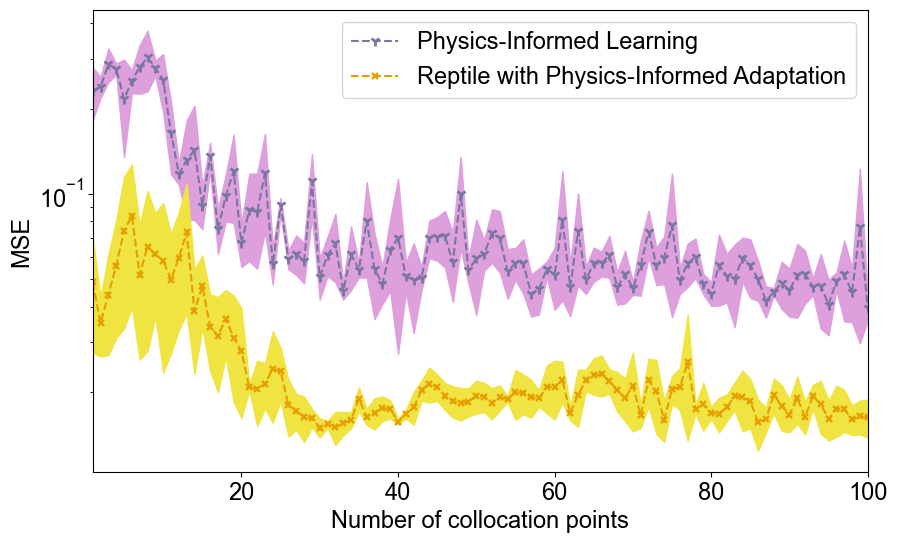

In [63]:
# Testing
test_loss_reference = [0.01]

size = 100
x = np.arange(1,size+1,1)

plt.figure(figsize=(10,6))
plt.rc('font', size=17)

plt.plot(x, test_loss_PI_batch_mean[:size], '--', color='#7976A2', marker='1', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Physics-Informed Learning')
plt.fill_between(x, test_loss_PI_batch_mean[:size] - test_loss_PI_batch_std[:size], test_loss_PI_batch_mean[:size] + test_loss_PI_batch_std[:size], edgecolor="plum", facecolor="plum")

plt.plot(x, test_loss_PI_reptile_batch_mean[:size], '--', color='#E69F00', marker='x', linewidth=1.5, markersize=5, markeredgewidth=1.75, label='Reptile with Physics-Informed Adaptation')
plt.fill_between(x, test_loss_PI_reptile_batch_mean[:size] - test_loss_PI_reptile_batch_std[:size], test_loss_PI_reptile_batch_mean[:size] + test_loss_PI_reptile_batch_std[:size], edgecolor="#F0E442", facecolor="#F0E442")

# plt.plot(x, test_loss_reference*(size), color='#E47159', linewidth=1.5, label='Reference MSE')

plt.legend()
plt.xlabel("Number of collocation points")
plt.ylabel("MSE")
plt.margins(x=0)
plt.yscale('log')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.savefig('batch_time.pdf')
plt.show()